## Review Work
#### Question: 
Q: Why is TIMB horrible for KNN but does so well for the GP, e.g. on ESM-1b? 

In [1]:
import sys
import os
import numpy as np
import random
from scipy.stats import multivariate_normal, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
from gpflow.kernels import SquaredExponential, Linear, Matern52

sys.path.insert(0, '..')
# prepare data
from data import load_dataset
from data.train_test_split import RandomSplitter
from util.preprocess import scale_observations
from algorithms.gp_on_real_space import GPonRealSpace
from algorithms.KNN import KNN

In [2]:
data = "TIMB"
rep = "esm"

_X, _Y = load_dataset(data, representation=rep)
train_idx, _ , test_idx = RandomSplitter(data).split(_X)

# on first split
X, Y = _X[train_idx[0]], _Y[train_idx[0]]
X_test, Y_test = _X[test_idx[0]], _Y[test_idx[0]]

# scale
mean_y, std_y, scaled_y = scale_observations(Y.copy())

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


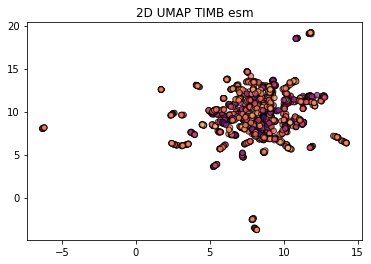

In [3]:
from make_plot_representations import plot_reduced_representations

plot_reduced_representations(data, rep)

### Fitted KNN

In [4]:
method_knn = KNN(optimize=True)
method_knn.train(X, scaled_y)

Score: 0.8465005455434795
Parameters: k=432


In [5]:
_mu_knn_train, _var_knn_train = method_knn.predict_f(X)

y_pred_knn_train = _mu_knn_train*std_y + mean_y
var_knn_train = _var_knn_train*std_y

_mu_knn_test, _var_knn_test = method_knn.predict_f(X_test)

y_pred_knn_test = _mu_knn_test*std_y + mean_y
var_knn_test = _var_knn_test * std_y

### Fitted GP

In [6]:
# GP for TIMB on RandomSplitter, fitted values: l_var = 0.23, len=0.2
# NOTE: we take the already optimized parameters here
method = GPonRealSpace(kernel_factory=lambda: Matern52(variance=0.23, lengthscales=0.2), optimize=False)
method.train(X, scaled_y)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-04-14 10:40:06.425737: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-14 10:40:06.425875: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
_mu, _var = method.predict(X) # NOTE: include data-noise for KNN comparison, for only model noise use predict_f

y_pred = _mu*std_y + mean_y
var = _var*std_y

In [8]:
_mu_test, _var_test = method.predict(X_test)

y_pred_test = _mu_test*std_y + mean_y
var_test = _var_test*std_y

In [9]:
_mu.shape, _var.shape

(TensorShape([1367, 1]), TensorShape([1367, 1]))

/Users/rcml/miniforge3/envs/env_tf/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/rcml/miniforge3/envs/env_tf/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/rcml/miniforge3/envs/env_tf/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error o

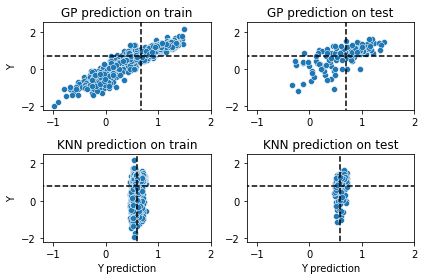

In [10]:
y_lim = (-2.2, 2.5)
x_lim = (-1.2, 2.)
fig, ax = plt.subplots(2,2)
sns.scatterplot(y_pred.numpy().flatten(), Y.flatten(), ax=ax[0,0])
sns.scatterplot(y_pred_test.numpy().flatten(), Y_test.flatten(), ax=ax[0,1])
sns.scatterplot(y_pred_knn_train.flatten(), Y.flatten(), ax=ax[1,0])
sns.scatterplot(y_pred_knn_test.flatten(), Y_test.flatten(), ax=ax[1,1])
ax[0,0].set_title("GP prediction on train")
ax[0,0].set_ylabel("Y")
ax[1,0].set_xlabel("Y prediction")
ax[0,1].set_title("GP prediction on test")
ax[1,0].set_title("KNN prediction on train")
ax[1,0].set_ylabel("Y")
ax[1,1].set_xlabel("Y prediction")
ax[1,1].set_title("KNN prediction on test")
ax[0,0].set_ylim(y_lim)
ax[1,0].set_ylim(y_lim)
ax[0,1].set_ylim(y_lim)
ax[1,1].set_ylim(y_lim)
ax[0,0].set_xlim(x_lim)
ax[1,0].set_xlim(x_lim)
ax[0,1].set_xlim(x_lim)
ax[1,1].set_xlim(x_lim)
ax[0,0].axvline(np.mean(y_pred.numpy().flatten()), y_lim[0], y_lim[1], c="k", linestyle="--")
ax[0,1].axvline(np.mean(y_pred_test.numpy().flatten()), y_lim[0], y_lim[1], c="k", linestyle="--")
ax[1,0].axvline(np.mean(y_pred_knn_train.flatten()), y_lim[0], y_lim[1], c="k", linestyle="--")
ax[1,1].axvline(np.mean(y_pred_knn_test.flatten()), y_lim[0], y_lim[1], c="k", linestyle="--")
ax[0,0].axhline(np.mean(Y.flatten()), x_lim[0], x_lim[1], c="k", linestyle="--")
ax[0,1].axhline(np.mean(Y.flatten()), x_lim[0], x_lim[1], c="k", linestyle="--")
ax[1,0].axhline(np.mean(Y_test.flatten()), x_lim[0], x_lim[1], c="k", linestyle="--")
ax[1,1].axhline(np.mean(Y_test.flatten()), x_lim[0], x_lim[1], c="k", linestyle="--")
plt.tight_layout()
plt.show()

Text(0.5, 0.98, 'Predictive variances (test) \n (GP data noise included)')

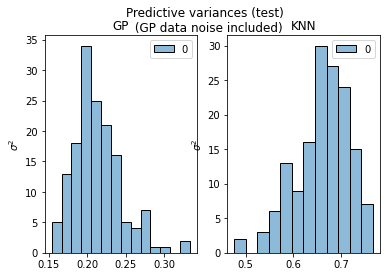

In [11]:
fig, ax = plt.subplots(1, 2)
sns.histplot(var_test, ax=ax[0])
sns.histplot(var_knn_test, ax=ax[1])
ax[0].set_title("GP")
ax[1].set_title("KNN")
ax[0].set_ylabel(r"$\sigma^2$")
ax[1].set_ylabel(r"$\sigma^2$")
plt.suptitle("Predictive variances (test) \n (GP data noise included)")

In [12]:
mvn_train = multivariate_normal(mean=y_pred.numpy().flatten(), cov=var.numpy().flatten())
mvn_test = multivariate_normal(mean=y_pred_test.numpy().flatten(), cov=var_test.numpy().flatten())
# draw from training

In [13]:
mvn_knn_train = multivariate_normal(mean=y_pred_knn_train.flatten(), cov=var_knn_train.flatten())
mvn_knn_test = multivariate_normal(mean=y_pred_knn_test.flatten(), cov=var_knn_test.flatten())

In [18]:
d_train_samples = mvn_train.rvs(size=5)
d_test_samples = mvn_test.rvs(size=5)
d_train_knn_samples = mvn_knn_train.rvs(size=5)
d_test_knn_samples = mvn_knn_test.rvs(size=5)

Text(0.5, 0.98, 'Distribution Samples')

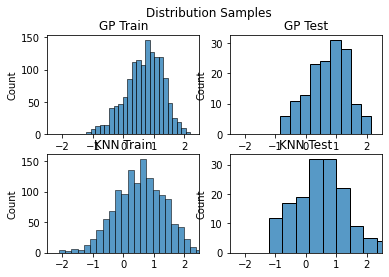

In [17]:
xlim=(-2.5, 2.5)
fig, ax = plt.subplots(2, 2)
sns.histplot(d_train_samples.flatten(), ax=ax[0,0])
sns.histplot(d_test_samples.flatten(), ax=ax[0,1])
sns.histplot(d_train_knn_samples.flatten(), ax=ax[1,0])
sns.histplot(d_test_knn_samples.flatten(), ax=ax[1,1])
ax[0,0].set_title("GP Train")
ax[0,0].set_xlim(xlim)
ax[0,1].set_xlim(xlim)
ax[1,0].set_xlim(xlim)
ax[1,1].set_xlim(xlim)
ax[0,1].set_title("GP Test")
ax[1,0].set_title("KNN Train")
ax[1,1].set_title("KNN Test")
plt.suptitle("Distribution Samples")

## Section Predictive Uncertainties
### and Extrapolation

Q: Can we add multiple mutations at random and rank by predictive uncertainties?

In [2]:
dataset = "1FQG"
N_mutants = 200
N_splits = 3

In [3]:
from data.load_dataset import load_one_hot
from data import load_dataset, get_alphabet
from util import numpy_one_hot_2dmat
from algorithm_factories import ALGORITHM_REGISTRY
from algorithm_factories import KNNFactory, UncertainRFFactory, GPMaternFactory, GPLinearFactory
import seaborn as sns
import pandas as pd

X_seq, _ = load_one_hot(dataset) # obtain original sequence

X_mutated = {}
# add mutations to X
for m_count in [2, 3, 4]:
    X_mutated[m_count] = []
    for _ in range(N_mutants): # make 1000 substitutions
        _X = X_seq[0].copy() # copy WT for mutation
        pos = random.sample(range(X_seq.shape[1]), m_count) # select positions, no duplicates
        aa = np.random.randint(0, 20, size=m_count) # select AA for substitutions, w/ duplicates
        while any([a==x for a,x in zip(aa, _X[pos])]):
            aa = np.random.randint(0, len(get_alphabet(dataset)), size=m_count) # redraw if same AA
        _X[pos] = aa
        assert sum(x!=y for x, y in zip(_X, X_seq[0])) == m_count # test that dist to WT is mutation count
        # one-hot encode mutated X
        X_mutated[m_count].append(_X)
    # one-hot encode and normalize by seq length
    X_mutated[m_count] = numpy_one_hot_2dmat(np.vstack(X_mutated[m_count]), max=len(get_alphabet(dataset))) / X_seq.shape[1]

In [4]:
# Training data
X, Y = load_dataset(dataset, representation="one_hot")
# Randomsplitting
train_indices, _, test_indices = RandomSplitter(dataset).split(X)

for method_factory in [UncertainRFFactory, KNNFactory, GPMaternFactory, GPLinearFactory, ]:
    method = method_factory("one_hot", alphabet=get_alphabet(dataset))
    print(f"Method: {method.get_name()}")
    for split in range(N_splits):
        X_train = X[train_indices[split], :]
        Y_train = Y[train_indices[split], :]
        X_test = X[test_indices[split], :]
        Y_test = Y[test_indices[split]]
        # STANDARDIZE OBSERVATIONS ON TRAIN
        mean_y, std_y, scaled_y = scale_observations(Y_train.copy())
        # SET PRIORS IF GP
        if "GP" in method.get_name() and X_train.shape[0] > 1: # set initial parameters based on distance in space if using full latent space
            init_len = np.max(np.abs(np.subtract(X_train[0], X_train[1])))
            eps = 0.001
            method.init_length = init_len if init_len > 0.0 else init_len+eps # if reduced on lower dim this value is too small
        # TRAIN MODEL:
        method.train(X_train, scaled_y)
        # PREDICT:
        _mu, _unc = method.predict_f(X_test)
        # undo scaling
        mu = _mu*std_y + mean_y
        unc = _unc*std_y
        assert(mu.shape[1] == 1 == unc.shape[1])
        assert(mu.shape[0] == unc.shape[0] == len(test_indices[split]))
        # record mean and median smse and nll and spearman correlation
        assert mu.shape == Y_test.shape, "shape mismatch "+str(mu.shape)+' '+str(Y_test.flatten().shape)
        # COMPUTE RESULT METRICS
        baseline = np.mean(np.square(Y_test - np.repeat(mean_y, len(Y_test)).reshape(-1,1)))
        err2 = np.square(Y_test - mu)
        mse = np.mean(err2)/baseline
        r = spearmanr(Y_test, mu)[0]  # we do not care about the p-value
        n = X_train.shape[0]
        print(f"Split={split}: r={r}, NMSE={mse}")

        # Test ranking multivariates
        mv_predictions = {}
        fractions = []
        for m_count in X_mutated.keys():
            _, _unc = method.predict(X_mutated[m_count])
            unc = _unc*std_y
            mv_predictions[m_count] = unc
        all_mv_predictive_variances = np.concatenate([val for val in mv_predictions.values()]).flatten()
        sort_idx = np.argsort(all_mv_predictive_variances)
        fractions = []
        for i, m_count in enumerate(X_mutated.keys()):
            # Test: how many pred.var fall into the respective mutation count interval
            # The higher the mutation count the higher the expected pred. var.
            frac = sum(sort_idx[N_mutants*i:N_mutants*(i+1)] < N_mutants*(i+1)) / N_mutants
            fractions.append(frac)

        print(f"Pred.Var. Sorted Variants: {fractions}; \n first & last 3 values=[{np.sort(np.unique(all_mv_predictive_variances))}]")  

        # visualize via boxplot per mutation
        sns.boxplot(data=pd.DataFrame({k: np.concatenate(v).flatten() for k, v in mv_predictions.items()}))
        plt.title(f"{method.get_name()}, predictive variance per mutation")
        plt.show()

Method: uncertainRF


KeyboardInterrupt: 